In [2]:
import tensorflow as tf
import os
import math
import numpy as np
import glob

from PIL import Image

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow import keras

# 이거 추가로 설치해줘야 됨
# from skimage.io import imread
# from skimage.transform import resize

# 요거 사용해도 됨
from tensorflow.keras.utils import load_img, img_to_array

import cv2

from Preprocessing import preprocess_image, crop_and_resize_image

import matplotlib.pyplot as plt

In [3]:
# tr : val : ts = 70 : 5 : 25 , 논문에 나와있음
# 1290, 92, 460  / 너무 적은 것 같다. 
# tr : val : ts = 70 : 10 : 20 으로 설정
# 1290, 184, 368
# 순서대로 짜르면 되겠다. 

In [6]:
# RandomGenerator

class DR_Generator(tf.keras.utils.Sequence):
    '''
    tf.keras.utils.Sequence를 상속받아 Sequence를 커스텀해 사용
    '''
    def __init__(self, 
               dir_path,
               mask_path=None,
               batch_size=4,
               img_size=(512, 512),
               dataset=None,
               start_end_index=None,
               is_train=True):
        '''
        dir_path (str): image path
        mask_path ([str]): mask path
        batch_size (int): batch_size
        img_size (224, 224, 3): 다루는 이미지 사이즈
        dataset (str) : 가져오려는 dataset 이름 , APTOS or FGADR or EyePacks      
        start_end_index : dataset 중 가져오려는 index의 시작과 끝
        '''
        self.dir_path = dir_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.dataset = dataset
        self.start_end_index = start_end_index
        

        # load_dataset()을 통해서 directory path에서 라벨과 이미지를 확인
        self.data_paths = self.load_dataset()

    def load_dataset(self):
        '''
        path 불러오는 함수  
        tr : val : ts = 70 : 10 : 20
        1290: 184: 368
        '''
        # 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수
        # is_train, is_valid, is_test로 분리함
        
        # 이미지 path 지정
        file_list = os.listdir(self.dir_path)
        input_images_paths = [os.path.join(self.dir_path, file) for file in file_list]
        input_images_paths.sort()

        # mask path 지정
        # unsupervsion 떄는 필요없음
        if self.mask_path:
          mask_images_paths = (os.path.join(self.mask_path, "semantic"))
          mask_images_paths.sort()

          # image와 label 길이가 같은지 확인
          assert len(input_images_paths) == len(mask_images_paths)
        
          # path 합치기
          data_paths = [ _ for _ in zip(input_images_paths, mask_images_paths)]
        
        else:
          data_paths = [_ for _ in zip(input_images_paths)]
        
        start, end = self.start_end_index
        return data_paths[start:end] 
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
        return math.ceil(len(self.data_paths) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만드는 함수
        # 입력은 전처리가 input image이고 
        # 출력은 semantic label
        batch_data_paths = self.data_paths[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        
        # 채널 수 바꿔줘야 됨
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.img_size])
        
        for i, data in enumerate(batch_data_paths):
            # supervsion 일때는 4개의 label
            # unsupervision 일때는 label이 image가 됨 
            if self.mask_path:
              input_img_path, output_path = data
            
            else:
              input_img_path,  = data
              output = 0
              
            # image
            _input = preprocess_image(input_img_path, img_size=self.img_size)
            # scale 0~255로 바꿔주기
            _input = _input / 255.0
            
            # mask
            _output = 0
            # _output = img_to_array(load_img(output_path, color_mode='grayscale'))
            # _output = (_output==7).astype(np.uint8)*1
            
            inputs[i] = _input
            outputs[i] = _output
        
        if self.dataset == "EyePacks":
           return inputs, inputs
        
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수
        # 학습중인 경우에 순서를 random shuffle하도록 적용
        self.indexes = np.arange(len(self.data_paths))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [7]:
generator_args = {
  'dir_path':'../data/train',
  'mask_path':None,
  'img_size':(512, 512),  
  'batch_size':4, # 8로 하면 바로 OOM 뜸
  'dataset':'EyePacks',
  'is_train':True
}

tr_eyepacks_gen = DR_Generator(start_end_index=(0, 5000), **generator_args)
val_eyepacks_gen = DR_Generator(start_end_index=(5000, 5100), **generator_args)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: '../data/train'

In [28]:
input.shape

(4, 512, 512)

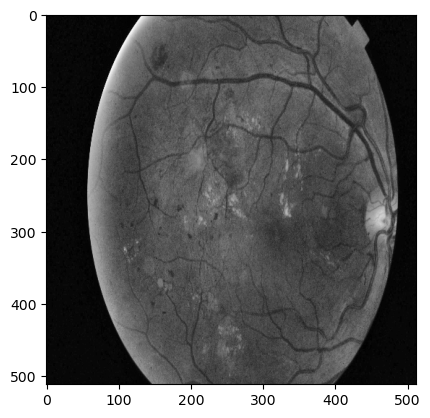

In [30]:
plt.imshow((input[0] * 255).astype(np.uint8), cmap='gray')